In [126]:
# Import the built-in Python module `os`, which provides utilities for interacting with the operating system
import os

# Import Python’s standard math library (scalar math functions/constants like sqrt, exp, pi, etc.)
import math

# Import NumPy and alias it as "np" for numerical computing with fast arrays/matrices and vectorized ops
import numpy as np

# Import Pandas and alias it as "pd" for tabular data structures (DataFrame/Series) and time-series handling
import pandas as pd

# Import SciPy’s griddata interpolator for interpolating scattered data points onto a structured grid
from scipy.interpolate import griddata

# Import SciPy’s normal distribution utilities; norm.cdf and norm.pdf are used in Black–Scholes Greeks/pricing
from scipy.stats import norm

# Import Matplotlib’s plotting interface and alias it as "plt" for creating figures and charts
import matplotlib.pyplot as plt

# Import the Line2D class from Matplotlib, which represents a 2D line/marker artist.
from matplotlib.lines import Line2D

# Import Matplotlib’s 3D plotting toolkit; enables 3D axes/projections
from mpl_toolkits.mplot3d import Axes3D

# Import TensorFlow, the ML framework used to build/train the ConvLSTM neural network
import tensorflow as tf

# Import Keras layers and model APIs from TensorFlow for defining neural-network architectures
from tensorflow.keras import layers, models

# Import training callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [127]:
# Allow pandas to display all DataFrame columns without truncation
pd.set_option("display.max_columns", None)
# Disable fixed console width so pandas uses the full available horizontal space
# (prevents columns from being wrapped or collapsed into "...")
pd.set_option("display.width", None)

# Define a fixed integer seed so that random number generation can be reproduced across runs.
SEED = 100
# Set Python's hash seed (affects hashing of strings/objects and therefore iteration order in some hash-based structures)
# to a fixed value to improve reproducibility.
os.environ["PYTHONHASHSEED"] = str(SEED)
# Request deterministic TensorFlow ops where supported (particularly relevant on GPU); this is an environment flag
# that TensorFlow checks to prefer deterministic algorithm implementations when available.
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # determinism where supported (esp. GPU)
# Set seeds for multiple RNG sources used by TensorFlow/Keras pipelines:
# - Python's built-in `random`
# - NumPy's RNG
# - TensorFlow's RNG
# This makes model initialization, shuffling, dropout, etc., more reproducible.
tf.keras.utils.set_random_seed(SEED)      # seeds: Python random + NumPy + TF
# Enable TensorFlow op determinism at runtime (TensorFlow will attempt to use deterministic kernels/algorithms
# for operations that have deterministic implementations).
tf.config.experimental.enable_op_determinism()

In [128]:
data = np.load("/kaggle/input/svi-inputs/vol_cube.npz")
vol_cube_train = data["train"]
vol_cube_test  = data["test"]

In [129]:
df_train_clean = pd.read_csv("/kaggle/input/svi-inputs/clean_train_chains.csv")
df_test_clean = pd.read_csv("/kaggle/input/svi-inputs/clean_test_chains.csv")
dates_train = pd.read_csv("/kaggle/input/svi-inputs/dates_train.csv")
dates_test = pd.read_csv("/kaggle/input/svi-inputs/dates_test.csv")
df_rates = pd.read_csv("/kaggle/input/svi-inputs/rates_interpolated.csv")

In [130]:
# Define the number of days in a year (used for converting day counts into year fractions in time-to-maturity calculations)
days_year = 365
# Set how many past time steps (e.g., trading days of IV surfaces) the model will look at as input for each training sample
lookback = 20
# Set the forecast horizon (how many steps ahead in time the model should predict the next IV surface)
horizon  = 5
# Set the maximum number of full passes through the training data during neural network training
epochs = 25
# Set the number of training samples processed before performing one gradient update (affects speed and optimization stability)
batch_size = 16
# Set the initial learning rate for the optimizer (controls the step size of parameter updates during training)
initial_lr = 1e-3
# Define a lower bound (floor) for implied volatility values to prevent invalid or numerically unstable near-zero/negative vols
iv_floor = 1e-6
# Define an upper bound (cap) for implied volatility values to prevent extreme/unrealistic vols or model/interpolation overshoot
iv_cap = 5.0

In [131]:
# Define a helper function that retrieves the risk-free rate for a specific date from the cleaned rates DataFrame
def get_rate(df, date):
  # Filter rows where the "Date" exactly equals the requested date, select the "Rate" value, and take the first match
  rate = df.loc[df["Date"].eq(date), "Rate"].iloc[0]
  # Return the matched risk-free rate value (in decimal form, e.g., 0.05 for 5%)
  return rate

In [132]:
# Define a function that converts a time series of IV surfaces ("vol_cube") into supervised learning samples
# using a rolling window of length (lookback + horizon).
def dataset_format(vol_cube):
  # Create a rolling/sliding view over the time axis (axis=0) without copying data:
  # each window contains (lookback + horizon) consecutive surfaces.
  vol_cube_arr = np.lib.stride_tricks.sliding_window_view(
      vol_cube,                              # the full time series of surfaces
      window_shape=lookback + horizon,       # total window length: input history + forecast offset
      axis=0                                 # slide along the time dimension
  )
  # Reorder axes to match the later model/data pipeline expectations:
  # from: (samples, time, channels, height, width) to (samples, window, height, width, channels)
  # This matches later slicing and Keras ConvLSTM input format after further reshaping.
  vol_cube_arr = np.transpose(vol_cube_arr, (0, 4, 2, 3, 1))
  # Return the formatted rolling-window array of samples
  return vol_cube_arr

In [133]:
# Define a function that splits the formatted dataset into training and validation subsets
def train_val_split(vol_cube_arr):
  # Get the number of available samples/windows in the dataset (i.e., the number of sliding windows)
  n = vol_cube_arr.shape[0]
  # Compute a split point as 20% of the samples (cast to int for indexing)
  n_train = int(0.2 * n)
  # Assign the later 80% of samples to the training set (everything from index n_train to the end)
  vol_cube_arr_train = vol_cube_arr[n_train:]
  # Assign the earlier portion to the validation set, stopping at n_train-(lookback+horizon)
  # (this subtracts a window length; in this notebook this ensures a non-empty validation slice,
  # but it also means validation is taken from earlier history)
  vol_cube_arr_val  = vol_cube_arr[:n_train - (lookback + horizon)]
  # Return the training and validation arrays
  return vol_cube_arr_train, vol_cube_arr_val

In [134]:
# Define a function that splits each rolling window into model inputs (x) and targets (y)
def create_x_y_frames(vol_cube_arr):
    # Take the first "lookback" time slices from each window as the input sequence x
    # (i.e., the historical IV surfaces the model will condition on)
    x = vol_cube_arr[:, 0:lookback, :, :]
    # Take the last time slice in each window as the prediction target y
    # (i.e., the IV surface at the end of the (lookback + horizon) window)
    y = vol_cube_arr[:, -1, :, :]
    # Return the input sequences and corresponding target surfaces
    return x, y

In [135]:
# Format the training vol cube into rolling windows of length (lookback + horizon) for supervised learning
vol_cube_arr_train = dataset_format(vol_cube_train)
# Split the formatted training windows into a training subset and a validation subset
vol_cube_arr_train_train, vol_cube_arr_train_val = train_val_split(vol_cube_arr_train)
# From the training subset, create model inputs (x: first lookback frames) and targets (y: last frame in each window)
x_vol_cube_arr_train_train, y_vol_cube_arr_train_train = create_x_y_frames(vol_cube_arr_train_train)
# From the validation subset, create model inputs (x) and targets (y) using the same slicing rule
x_vol_cube_arr_train_val, y_vol_cube_arr_train_val = create_x_y_frames(vol_cube_arr_train_val)
# Format the test vol cube into rolling windows of length (lookback + horizon) so we can generate test inputs/targets
vol_cube_arr_test = dataset_format(vol_cube_test)
# Create test inputs (x) and test targets (y) from the formatted test windows
x_vol_cube_arr_test, y_vol_cube_arr_test = create_x_y_frames(vol_cube_arr_test)

In [136]:
frames_mean = x_vol_cube_arr_train_train.mean(axis=(0, 1, 2, 3), keepdims=True)
frames_std  = x_vol_cube_arr_train_train.std(axis=(0, 1, 2, 3), keepdims=True)

x_vol_cube_arr_train_train_norm = (x_vol_cube_arr_train_train - frames_mean) / frames_std
x_vol_cube_arr_train_val_norm   = (x_vol_cube_arr_train_val   - frames_mean) / frames_std

x_vol_cube_arr_test_norm = (x_vol_cube_arr_test - frames_mean) / frames_std

In [137]:
def ds_pi_from_windows(x_frames, y_next, batch=8, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((x_frames, y_next))
    if shuffle:
        ds = ds.shuffle(len(x_frames), seed=SEED, reshuffle_each_iteration=False)

    def _map(frames, y):
        tau   = y[..., 0:1]
        sigma = y[..., 1:2]
        S     = y[..., 2:3]
        r     = y[..., 3:4]
        K     = y[..., 4:5]
        zeros = tf.zeros_like(sigma)

        frames = tf.cast(frames, tf.float32)
        tau, sigma, S, r, K = [tf.cast(t, tf.float32) for t in (tau, sigma, S, r, K)]

        inputs  = (frames, tau, S, r, K)
        targets = (sigma, zeros)
        return inputs, targets

    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE) \
             .batch(batch) \
             .prefetch(tf.data.AUTOTUNE)

train_ds = ds_pi_from_windows(x_vol_cube_arr_train_train_norm, y_vol_cube_arr_train_train, batch=16, shuffle=True)
val_ds   = ds_pi_from_windows(x_vol_cube_arr_train_val_norm,   y_vol_cube_arr_train_val,   batch=16, shuffle=False)
test_ds   = ds_pi_from_windows(x_vol_cube_arr_test_norm, y_vol_cube_arr_test,   batch=16, shuffle=False)

In [138]:
moneyness_grid = np.arange(0.90, 1.09, 0.01)
ttm_grid = np.arange(90, 660+1, 30)/days_year
M_grid, TTM_grid = np.meshgrid(moneyness_grid, ttm_grid)

In [139]:
# Compute the grid height as the number of distinct TTM (time-to-expiration) levels in the surface grid
# This will be the number of rows in each interpolated IV surface.
height = len(ttm_grid)
# Compute the grid width as the number of distinct moneyness levels in the surface grid
# This will be the number of columns in each interpolated IV surface.
width = len(moneyness_grid)

In [140]:
# Set the grid height (number of rows) used by the model
H = height
# Set the grid width (number of columns) used by the model
W = width
# Define the number of input channels per frame.
# For a single implied-volatility surface per time step, this is typically 1.
IN_CH = 5
# Define how many past time steps (frames/surfaces) the model receives as input.
# Here it is tied directly to your `lookback` hyperparameter.
SEQ_LEN = lookback
# Set the internal embedding width (feature channels) used throughout attention/conv blocks.
# This is the model’s main hidden dimension D.
D = 32
# Set the number of attention heads used in multi-head attention layers.
# Requirement: D must be divisible by HEADS so each head has equal `head_dim = D // HEADS`.
HEADS = 4
# Set the negative slope for LeakyReLU activations used throughout the network.
# Larger values allow more gradient flow for negative activations.
LRELU_ALPHA = 0.1
# Toggle whether to use the deeper SFFN head (True) or a simple 1x1 Conv2D output head (False).
USE_SFFN = False
# Set the depth (number of Conv+activation blocks) for the SFFN head.
# This value is only used when USE_SFFN = True.
SFFN_DEPTH = 30
# Set the convolution kernel size used by Conv2D layers in the model
kernel_size = 5

In [141]:
def C3(x, filters, name=None):
    # Apply a 2D convolution to tensor x, producing `filters` output channels.
    x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=True, name=name)(x)
    # Apply LeakyReLU nonlinearity with slope `LRELU_ALPHA` for negative inputs.
    x = layers.LeakyReLU(negative_slope=LRELU_ALPHA)(x)
    # Return the transformed tensor.
    return x

class SinusoidalTimePE(layers.Layer):
    def __init__(self, seq_len, channels, **kwargs):
        # Initialize the parent Layer. dtype=None lets Keras infer dtype handling.
        super().__init__(dtype=None, **kwargs)
        # Store the sequence length (time dimension) as an integer.
        self.seq_len = int(seq_len)
        # Store the number of channels to generate positional encodings for.
        self.channels = int(channels)

    def call(self, x):
        # Batch size B inferred dynamically from input tensor x.
        B = tf.shape(x)[0]
        # Time length T is fixed to the configured sequence length.
        T = self.seq_len
        # Height H inferred dynamically.
        H = tf.shape(x)[2]
        # Width W inferred dynamically.
        W = tf.shape(x)[3]
        # Channels C is fixed to the configured channel count.
        C = self.channels

        # Create time positions t = [0..T-1] as float32, shaped (T, 1).
        t = tf.cast(tf.range(T)[:, None], tf.float32)
        # Create channel indices i = [0..C-1] as float32, shaped (1, C).
        i = tf.cast(tf.range(C)[None, :], tf.float32)
        # Compute denominators for sinusoidal frequencies:
        # denom[i] = 10000^(2*floor(i/2)/C), matching the Transformer formulation.
        denom = tf.pow(10000.0, (2.0 * tf.floor(i / 2.0)) / tf.cast(C, tf.float32))
        # Compute angles = t / denom, giving a (T, C) matrix of phase angles.
        angles = t / denom

        # Take sin on even channels: 0,2,4,... resulting shape (T, ceil(C/2)).
        sin = tf.sin(angles[:, 0::2])
        # Take cos on odd channels: 1,3,5,... resulting shape (T, floor(C/2)).
        cos = tf.cos(angles[:, 1::2])

        # Stack sin and cos along a new last axis and reshape to interleave them:
        # shape becomes (T, 2*min(...)) then flattened to (T, ?).
        interleaved = tf.reshape(tf.stack([sin, cos], axis=-1), (T, -1))
        # Truncate/pad by slicing to exactly C channels: shape (T, C).
        pe32 = interleaved[:, :C]

        # Reshape to broadcast over batch and spatial dims: (1, T, 1, 1, C).
        pe32 = tf.reshape(pe32, (1, T, 1, 1, C))
        # Tile to match input x shape: (B, T, H, W, C).
        pe32 = tf.tile(pe32, [B, 1, H, W, 1])

        # Cast PE to match x dtype (e.g., float16/float32).
        pe = tf.cast(pe32, x.dtype)
        # Add positional encoding to x and return.
        return x + pe                             

    def compute_output_shape(self, input_shape):
            # Positional encoding addition preserves shape.
            return input_shape


class MultiConvAttn(layers.Layer):
    def __init__(self, width, heads, name=None):
        # Initialize the layer with an optional name.
        super().__init__(name=name)
        # Ensure width is divisible by heads so each head has equal channel dims.
        assert width % heads == 0, "D must be divisible by HEADS"
        # Total channel width D.
        self.width = width
        # Number of attention heads.
        self.heads = heads
        # Per-head channel width.
        self.head_dim = width // heads

        # For each head, create a Conv2D that maps query head -> Q features.
        self.q_convs = [layers.Conv2D(self.head_dim, kernel_size, padding="same", use_bias=True)
                        for _ in range(heads)]
        # For each head, create a Conv2D that maps memory head -> KV features (used as both K and V).
        self.kv_convs = [layers.Conv2D(self.head_dim, kernel_size, padding="same", use_bias=True)
                         for _ in range(heads)]
        # For each head, create a Conv2D that maps concatenated [Q, K] -> scalar score logits.
        self.score_convs = [layers.Conv2D(1, kernel_size, padding="same", use_bias=True)
                            for _ in range(heads)]
        # Activation used throughout.
        self.act = layers.LeakyReLU(negative_slope=LRELU_ALPHA)

    def call(self, memory, query):
        # Batch size.
        B = tf.shape(memory)[0]
        # Time length.
        T = tf.shape(memory)[1]
        # Spatial height.
        H = tf.shape(memory)[2]
        # Spatial width.
        W = tf.shape(memory)[3]

        # Split memory channels into heads along the last axis:
        # list of `heads` tensors each shaped (B, T, H, W, head_dim).
        mem_heads = tf.split(memory, self.heads, axis=-1)
        # Split query channels into heads:
        # list of `heads` tensors each shaped (B, H, W, head_dim).
        q_heads   = tf.split(query,  self.heads, axis=-1)

        # Accumulator for per-head outputs.
        out_heads = []
        # Loop over heads.
        for h in range(self.heads):
            # Memory for head h: (B, T, H, W, head_dim).
            m_h = mem_heads[h]
            # Query for head h: (B, H, W, head_dim).
            q_h = q_heads[h]

            # Compute Q from query via convolution: (B, H, W, head_dim).
            Q = self.q_convs[h](q_h)
            # Apply activation.
            Q = self.act(Q)

            # Flatten batch and time to apply kv_conv as a regular Conv2D:
            # M_flat: (B*T, H, W, head_dim).
            M_flat = tf.reshape(m_h, (-1, H, W, self.head_dim))
            # Compute KV features: (B*T, H, W, head_dim).
            KV_flat = self.kv_convs[h](M_flat)
            # Apply activation.
            KV_flat = self.act(KV_flat)
            # Restore time dimension: KV: (B, T, H, W, head_dim).
            KV = tf.reshape(KV_flat, (B, T, H, W, self.head_dim))
            # Use the same tensor as both K and V (not a separate projection).
            K, V = KV, KV

            # Tile Q across time so it can be paired with K for each time step:
            # Q_tiled: (B, T, H, W, head_dim).
            Q_tiled = tf.tile(Q[:, None, ...], [1, T, 1, 1, 1])
            # Concatenate Q and K along channels for scoring: (B, T, H, W, 2*head_dim).
            qk = tf.concat([Q_tiled, K], axis=-1)
            # Flatten B and T to apply a Conv2D scoring network:
            # qk_flat: (B*T, H, W, 2*head_dim).
            qk_flat = tf.reshape(qk, (-1, H, W, 2 * self.head_dim))
            # Produce scalar logits per pixel: S_flat: (B*T, H, W, 1).
            S_flat = self.score_convs[h](qk_flat)
            # Apply activation to logits (note: this changes the usual “raw logits” convention).
            S_flat = self.act(S_flat)
            # Restore time dimension: S: (B, T, H, W, 1).
            S = tf.reshape(S_flat, (B, T, H, W, 1))

            # Softmax over time axis so attention weights sum to 1 across T:
            # A: (B, T, H, W, 1).
            A = tf.nn.softmax(S, axis=1)

            # Weighted sum over time of the value tensor V:
            # result Out: (B, H, W, head_dim).
            Out = tf.reduce_sum(A * V, axis=1)
            # Store head output.
            out_heads.append(Out)

        # Concatenate head outputs back to (B, H, W, width=D).
        return tf.concat(out_heads, axis=-1)


class EncoderLayer(layers.Layer):
    def __init__(self, width, heads, seq_len):
        # Initialize base Layer.
        super().__init__()
        # Multi-head convolutional attention module.
        self.attn = MultiConvAttn(width, heads, name="MultiConvAttn1")
        # LayerNorm after attention residual.
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        # Convolution used as a per-frame feed-forward block.
        self.conv_enc = layers.Conv2D(width, kernel_size, padding="same", use_bias=True, name="W_enc")
        # Activation for feed-forward.
        self.act = layers.LeakyReLU(negative_slope=LRELU_ALPHA)
        # LayerNorm after feed-forward residual.
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        # Store sequence length for looping over time steps.
        self.seq_len = seq_len

    def call(self, x):
        # Collect attention outputs for each time position.
        outs = []
        # Iterate over time index k.
        for k in range(self.seq_len):
            # Use frame k as the query: q_k shape (B, H, W, D).
            q_k = x[:, k, ...]
            # Attend over the whole sequence x using q_k as query:
            # out_k shape (B, H, W, D).
            out_k = self.attn(x, q_k)
            # Append result.
            outs.append(out_k)
        # Stack per-k outputs into a sequence: (B, T, H, W, D).
        attn_seq = tf.stack(outs, axis=1)

        # Residual connection + LayerNorm: output remains (B, T, H, W, D).
        x = self.norm1(x + attn_seq)

        # Flatten time into batch to apply Conv2D per frame:
        # x_flat: (B*T, H, W, D).
        x_flat = tf.reshape(x, (-1, tf.shape(x)[2], tf.shape(x)[3], tf.shape(x)[4]))
        # Apply convolutional feed-forward: (B*T, H, W, D).
        y_flat = self.conv_enc(x_flat)
        # Apply activation.
        y_flat = self.act(y_flat)
        # Restore sequence shape: y is (B, T, H, W, D).
        y = tf.reshape(y_flat, tf.shape(x))

        # Residual connection + LayerNorm.
        x = self.norm2(x + y)
        # Return encoded sequence.
        return x


class DecoderLayer(layers.Layer):
    def __init__(self, width, heads):
        # Initialize base Layer.
        super().__init__()
        # First cross-attention module (memory -> query).
        self.attn2 = MultiConvAttn(width, heads, name="MultiConvAttn2")
        # Norm after first attention residual.
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        # Second cross-attention module (memory -> refined query).
        self.attn3 = MultiConvAttn(width, heads, name="MultiConvAttn3")
        # Norm after second attention residual.
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        # Convolution used as a feed-forward block on the query.
        self.conv_dec = layers.Conv2D(width, kernel_size, padding="same", use_bias=True, name="W_dec")
        # Activation for feed-forward.
        self.act = layers.LeakyReLU(negative_slope=LRELU_ALPHA)
        # Norm after feed-forward residual.
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, memory, query):
        # Cross-attend query to memory, add residual, apply norm.
        q = self.norm1(query + self.attn2(memory, query))
        # Cross-attend again using the updated q, add residual, apply norm.
        q = self.norm2(q + self.attn3(memory, q))
        # Feed-forward conv with activation, residual, then norm.
        q = self.norm3(q + self.act(self.conv_dec(q)))
        # Return decoded query representation.
        return q

def sffn_head(x, depth=SFFN_DEPTH, max_ch=128, base_ch=D):
    # Convenience lambda for applying LayerNorm with a specific epsilon.
    ln = lambda z: layers.LayerNormalization(epsilon=1e-5)(z)
    # Number of steps for the "up" channel ramp.
    up_steps = depth // 2
    # Remaining steps for the "down" channel ramp.
    down_steps = depth - up_steps
    # Up-ramp: gradually increase channels from base_ch to max_ch.
    for i in range(up_steps):
        # Compute interpolated channel count for this stage.
        ch = int(round(base_ch + (max_ch - base_ch) * (i + 1) / up_steps))
        # Apply conv + LeakyReLU block.
        x = C3(x, ch, name=f"sffn_up_{i}")
        # Every 2 blocks, apply LayerNorm.
        if (i+1) % 2 == 0: x = ln(x)
    # Down-ramp: gradually decrease channels from max_ch back toward base_ch (min 8).
    for i in range(down_steps):
        # Fractional progress through down steps.
        frac = (i + 1) / down_steps
        # Compute decreasing channel count with a minimum of 8.
        ch = max(int(round(max_ch - (max_ch - base_ch) * frac)), 8)
        # Apply conv + LeakyReLU block.
        x = C3(x, ch, name=f"sffn_down_{i}")
        # Every 2 blocks, apply LayerNorm.
        if (i+1) % 2 == 0: x = ln(x)
    # Final 1x1 convolution to produce a single output channel.
    x = layers.Conv2D(1, 1, padding="same", name="W_final")(x)
    # Return output map.
    return x

def geometric_schedule(D, L=4, min_filters=4):
    # Compute the smallest base filter count such that base*(2^(L-1)) >= D, but at least min_filters.
    base = max(min_filters, int(math.ceil(D / (2 ** (L - 1)))))
    # Build a list of L filter sizes increasing geometrically by factors of 2, capped at D.
    filters = [min(D, base * (2 ** i)) for i in range(L)]
    # Force last stage to be exactly D.
    filters[-1] = D
    # Return the channel schedule list.
    return filters

def embedding_stack(x, D, L=4, min_filters=4):
    # Create the list of filter sizes to use across the embedding stack.
    filters_list = geometric_schedule(D=D, L=L, min_filters=min_filters)

    # Iterate through the schedule and apply TimeDistributed conv blocks.
    for f in filters_list:
        # Apply Conv2D independently to each time step: (B, T, H, W, channels).
        x = layers.TimeDistributed(layers.Conv2D(f, kernel_size, padding="same", use_bias=True))(x)
        # Apply LeakyReLU independently to each time step.
        x = layers.TimeDistributed(layers.LeakyReLU(negative_slope=LRELU_ALPHA))(x)
    # Return embedded sequence.
    return x

In [142]:
def normal_cdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / tf.sqrt(tf.constant(2.0, x.dtype))))

def bs_call_price(S, K, r, tau, sigma, eps=1e-8):
    tau = tf.maximum(tau, eps)
    sigma = tf.maximum(sigma, eps)

    sqrt_tau = tf.sqrt(tau)
    d1 = (tf.math.log(tf.maximum(S, eps)/tf.maximum(K, eps)) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau

    Phi_d1 = normal_cdf(d1)
    Phi_d2 = normal_cdf(d2)
    disc = tf.exp(-r * tau)
    return S * Phi_d1 - K * disc * Phi_d2

class BlackScholesResidual(layers.Layer):
    def call(self, sigma_pred, tau, S, r, K):
        sigma32 = tf.cast(sigma_pred, tf.float32)
        tau32   = tf.cast(tau, tf.float32)
        S32     = tf.cast(S, tf.float32)
        r32     = tf.cast(r, tf.float32)
        K32     = tf.cast(K, tf.float32)

        with tf.GradientTape() as t2:
            t2.watch(S32)

            with tf.GradientTape() as t1:
                t1.watch([tau32, S32])
                C = bs_call_price(S32, K32, r32, tau32, sigma32)

            dC_dtau, dC_dS = t1.gradient(C, [tau32, S32])

        d2C_dS2 = t2.gradient(dC_dS, S32)

        resid32 = dC_dtau + r32 * C - r32 * S32 * dC_dS - 0.5 * (sigma32**2) * (S32**2) * d2C_dS2

        return tf.cast(resid32, sigma_pred.dtype)

def build_pi_convtf(seq_len=30, height=20, width=20, d=32, heads=4, use_sffn=False, in_ch = 5, lrelu_alpha=0.1):
    frames = layers.Input((seq_len, height, width, in_ch), name="frames_5ch")

    tau_n1 = layers.Input((height, width, 1), name="tau_next")
    S_n1   = layers.Input((height, width, 1), name="S_next")
    r_n1   = layers.Input((height, width, 1), name="r_next")
    K_n1   = layers.Input((height, width, 1), name="K_next")

    x = embedding_stack(frames, D=D, L=4, min_filters=4) 

    x = SinusoidalTimePE(seq_len, d, name="posenc")(x)


    memory = EncoderLayer(d, heads, seq_len)(x)

    last_frame = layers.Lambda(lambda t: t[:, -1, ...], name="take_last_frame")(frames)
    q = C3(last_frame, d, name="Wdec_in")

    q = DecoderLayer(d, heads)(memory, q)

    if use_sffn:
        sigma_pred = sffn_head(q, depth=SFFN_DEPTH, max_ch=128, base_ch=d) 
    else:
        sigma_pred = layers.Conv2D(1, 1, padding="same", name="Data")(q)

    resid = BlackScholesResidual(name="Residual")(sigma_pred, tau_n1, S_n1, r_n1, K_n1)

    return models.Model(
        inputs=[frames, tau_n1, S_n1, r_n1, K_n1],
        outputs=[sigma_pred, resid],
        name="PI_ConvTF"
    )

pi_model = build_pi_convtf(seq_len=SEQ_LEN, height=H, width=W, d=D, heads=HEADS, use_sffn=USE_SFFN, in_ch = IN_CH, lrelu_alpha=LRELU_ALPHA)

LAMBDA = 0.1

pi_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr, epsilon=1e-4, clipnorm=1.0),
    loss=[tf.keras.losses.MeanAbsolutePercentageError(), "mae"],
    metrics=["mae", tf.keras.metrics.MeanAbsolutePercentageError()],
    loss_weights=[1.0, LAMBDA],
    run_eagerly=False)

pi_model.summary(line_length=120)

Model: "PI_ConvTF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ frames_5ch (InputLayer)           │ (None, 20, 20, 20, 5)        │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_16               │ (None, 20, 20, 20, 4)        │               504 │ frames_5ch[0][0]          
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_17               │ (None, 20, 20, 20, 4)        │                 0 │ time_distributed_16[0][0] 
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_18               │ (None, 20, 20, 20, 8)        │               808 │ time_distributed_17[0][0] 
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_19               │ (None, 20, 20, 20, 8)        │                 0 │ time_distributed_18[0][0] 
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_20               │ (None, 20, 20, 20, 16)       │             3,216 │ time_distributed_19[0][0] 
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_21               │ (None, 20, 20, 20, 16)       │                 0 │ time_distributed_20[0][0] 
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_22               │ (None, 20, 20, 20, 32)       │            12,832 │ time_distributed_21[0][0] 
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed_23               │ (None, 20, 20, 20, 32)       │                 0 │ time_distributed_22[0][0] 
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ take_last_frame (Lambda)          │ (None, 20, 20, 5)            │                 0 │ frames_5ch[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ posenc (SinusoidalTimePE)         │ (None, 20, 20, 20, 32)       │                 0 │ time_distributed_23[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ Wdec_in (Conv2D)                  │ (None, 20, 20, 32)           │             4,032 │ take_last_frame[0][0]     
├───────────────────────────────────┼───────────────────

 Total params: 116,413 (454.74 KB)

 Trainable params: 116,413 (454.74 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
# Create a callback that reduces the learning rate when the validation loss stops improving
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                                                        monitor="val_loss",   # watch the validation loss to decide when training has stalled
                                                        factor=0.5,           # multiply the current learning rate by 0.5 when triggered (i.e., reduce by 50%)
                                                        patience=2,           # wait for 2 epochs with no improvement before reducing the learning rate
                                                        verbose=1,            # print a message whenever the learning rate is reduced
                                                        min_lr=1e-6)          # do not reduce the learning rate below 1e-6

# Train the model on the training dataset and evaluate on the validation dataset each epoch
history = pi_model.fit(
                    train_ds,                 # training dataset providing (x, y) batches
                    validation_data=val_ds,   # validation dataset used to compute val_loss/val_metrics each epoch
                    epochs=epochs,            # maximum number of epochs (full passes over ds_train)
                    callbacks=[reduce_on_plateau],  # apply the learning-rate scheduler during training
                    verbose=1)                # print per-epoch training progress/logs

Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 558ms/step - Data_loss: 140.9601 - Data_mae: 0.3956 - Residual_loss: 2.8050e-06 - Residual_mean_absolute_percentage_error: 2804.9258 - loss: 140.9718 - val_Data_loss: 28.4687 - val_Data_mae: 0.0717 - val_Residual_loss: 1.6398e-06 - val_Residual_mean_absolute_percentage_error: 1636.4834 - val_loss: 28.4063 - learning_rate: 0.0010
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - Data_loss: 18.0332 - Data_mae: 0.0504 - Residual_loss: 2.9947e-06 - Residual_mean_absolute_percentage_error: 2994.6655 - loss: 18.0345 - val_Data_loss: 8.2966 - val_Data_mae: 0.0220 - val_Residual_loss: 1.5892e-06 - val_Residual_mean_absolute_percentage_error: 1586.6624 - val_loss: 8.3152 - learning_rate: 0.0010
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 409ms/step - Data_loss: 15.6187 - Data_mae: 0.0442 - Residual_loss: 2.9909e-06 - Residual_mean_absolute_percentage_error: 2990.9404 - loss: 15.6187 - val_Data_loss: 9.2003 - val_Data_mae: 0.0245 - val_Residual_loss: 

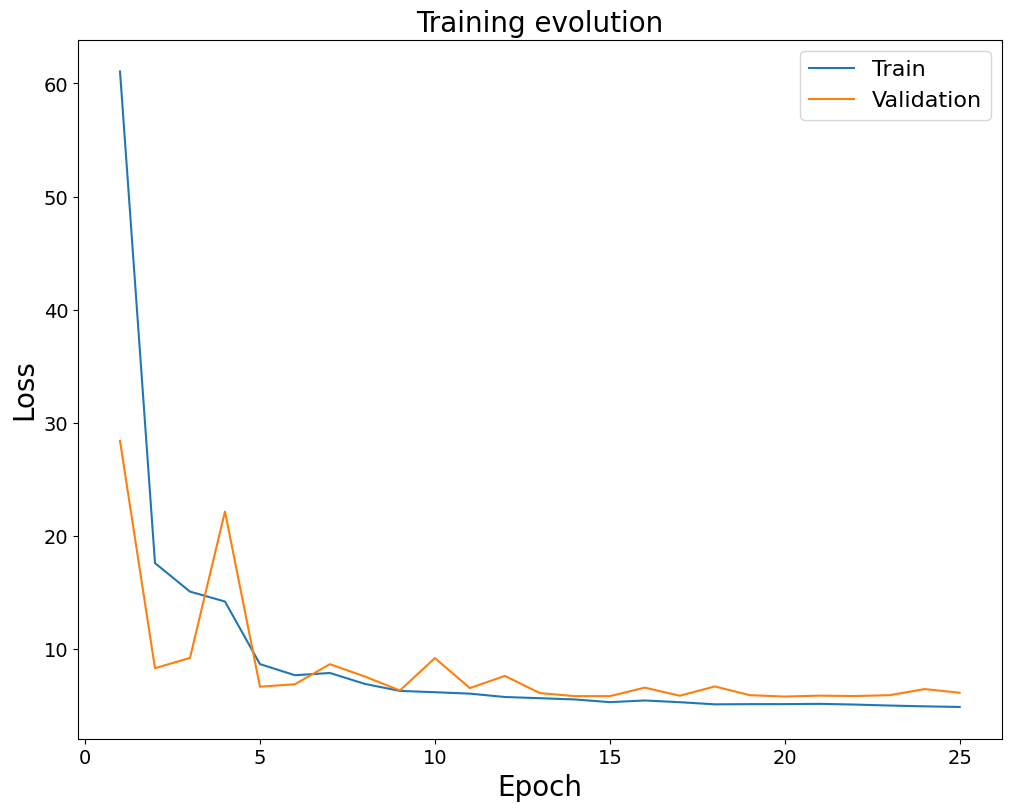

In [144]:
# Extract the training history dictionary recorded by Keras during model.fit()
hist = history.history
# Create a 1-based sequence of epoch numbers matching the length of the recorded loss series
epochs = range(1, len(hist.get("loss", [])) + 1)
# Create a new Matplotlib figure (a blank canvas for the plot)
plt.figure(figsize=(10, 8), constrained_layout=True)
# Plot the training loss values versus epoch number
plt.plot(epochs, hist["loss"], label="Train")
# If validation loss was recorded, plot it as well for comparison
if "val_loss" in hist:
    plt.plot(epochs, hist["val_loss"], label="Validation")
# Set the plot title to describe what is being shown
plt.title("Training evolution", fontsize=20)
# Label the x-axis as epoch number
plt.xlabel("Epoch", fontsize=20)
# Label the y-axis as the loss value (MAPE in this training setup)
plt.ylabel("Loss", fontsize=20)
# Add a legend to distinguish the training and validation curves
plt.legend(fontsize=16)
# Increase the font size of the x-axis tick labels (the numbers/labels along the bottom axis)
plt.xticks(fontsize=14)
# Increase the font size of the y-axis tick labels (the numbers/labels along the left axis)
plt.yticks(fontsize=14)
# Save the figure to a PNG file named with the sample index, at 300 DPI, trimming extra whitespace around the plot.
plt.savefig("training_curve.png", dpi=300, bbox_inches="tight")
# Render the plot to the output (e.g., in the notebook cell output)
plt.show()

In [145]:
# Run the model's evaluation loop on the test dataset and collect metrics in a dict.
# - `test_ds` is a `tf.data.Dataset` yielding batches of (inputs, targets).
# - `batch_size` controls how many samples are processed per step (may be ignored if `test_ds` is already batched).
# - `return_dict=True` returns a {metric_name: value} dictionary instead of a list.
# - `verbose=1` prints a progress bar / step-level progress during evaluation.
results = pi_model.evaluate(test_ds, batch_size=batch_size, return_dict=True, verbose=1)

# Print a header to visually separate evaluation output from other logs.
print("\n=== Test metrics ===")

# Iterate over each metric name/value pair returned by `model.evaluate(...)`.
for k, v in results.items():
    # Print the metric name and its value, formatting the value to 6 decimal places.
    print(f"{k}: {v:.6f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - Data_loss: 5.4812 - Data_mae: 0.0165 - Residual_loss: 2.1633e-06 - Residual_mean_absolute_percentage_error: 2163.1775 - loss: 5.4733

=== Test metrics ===
Data_loss: 5.817326
Data_mae: 0.017349
Residual_loss: 0.000002
Residual_mean_absolute_percentage_error: 2254.168701
loss: 5.675801


In [146]:
tau_next   = y_vol_cube_arr_test[..., 0:1]
S_next     = y_vol_cube_arr_test[..., 2:3]
r_next     = y_vol_cube_arr_test[..., 3:4]
K_next     = y_vol_cube_arr_test[..., 4:5]
real_volatility_surface_th = np.squeeze(y_vol_cube_arr_test[..., 1:2])

In [147]:
predicted_volatility_surface_th, resid_test = pi_model.predict([x_vol_cube_arr_test_norm, tau_next, S_next, r_next, K_next], batch_size=16, verbose=1,)

# Clamp the predicted IV values to a safe, valid range to avoid negatives or extreme outputs
predicted_volatility_surface_th = np.clip(
    predicted_volatility_surface_th,  # the array being clipped
    iv_floor,                             # minimum allowed IV value (floor)
    iv_cap                               # maximum allowed IV value (cap)
)

2025-12-21 18:54:30.237748: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_18}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step


In [148]:
real_volatility_surface_t = np.squeeze(x_vol_cube_arr_test[:, -1, :, :, 1])
predicted_volatility_surface_th = np.squeeze(predicted_volatility_surface_th)

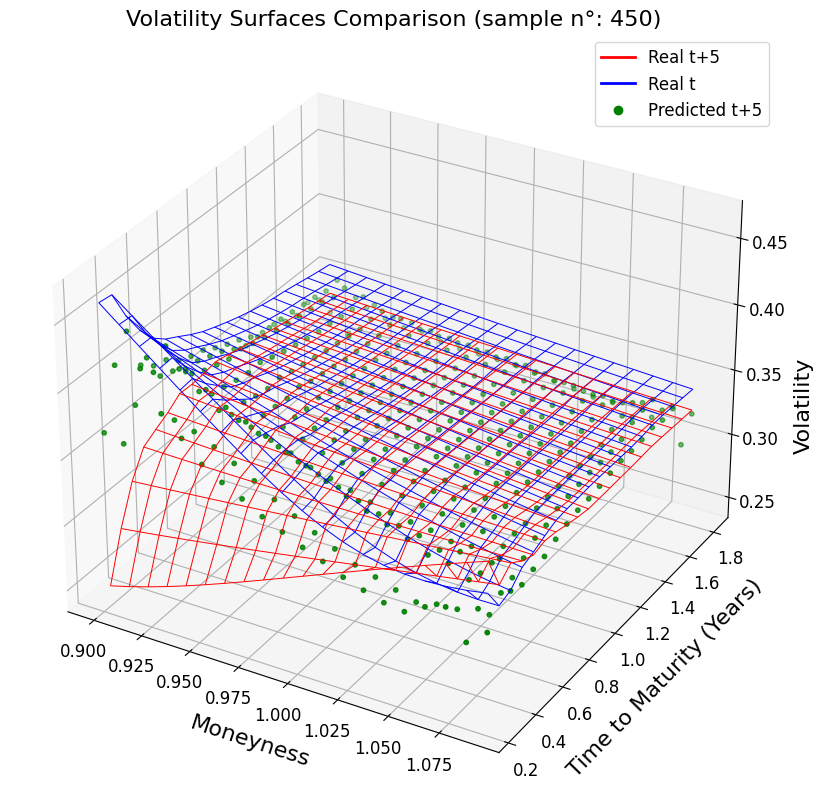

In [149]:
# Select the index of the test sample (i.e., which test window/surface to visualize).
i = 450
# Extract the ground-truth future volatility surface for sample i and remove any singleton dimensions (e.g., channel=1).
real_volatility_surface_th_i = np.squeeze(real_volatility_surface_th[i])
# Extract the model-predicted future volatility surface for sample i and remove any singleton dimensions.
predicted_volatility_surface_th_i = np.squeeze(predicted_volatility_surface_th[i])
# Extract the last observed (time t) volatility surface from the input sequence for sample i and remove any singleton dimensions.
real_volatility_surface_t_i = np.squeeze(real_volatility_surface_t[i])
# Create a Matplotlib figure with a specified size (15x6 inches) and enable constrained_layout to reduce label clipping.
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
# Add a single 3D axes to the figure (1 row, 1 column, first subplot) with 3D projection enabled.
ax = fig.add_subplot(111, projection='3d')
# Plot the real (ground-truth) future surface as a red wireframe over the (Moneyness, TTM) grid.
ax.plot_wireframe(
    M_grid, TTM_grid, real_volatility_surface_th_i,   # X, Y grids and Z values
    color='r', linewidth=0.7                          # Styling: red lines, thin wireframe
)
# Plot the real surface at time t (most recent observed surface) as a blue wireframe for comparison.
ax.plot_wireframe(
    M_grid, TTM_grid, real_volatility_surface_t_i,    # X, Y grids and Z values
    color='b', linewidth=0.7                          # Styling: blue lines, thin wireframe
)
# Plot the predicted future surface as green scatter points at each (Moneyness, TTM) grid location.
ax.scatter(
    M_grid, TTM_grid, predicted_volatility_surface_th_i,  # X, Y grids and predicted Z values
    s=10, color='g'                                       # Styling: point size 10, green markers
)
# Set the plot title and include the sample index i for traceability/reproducibility.
ax.set_title(f"Volatility Surfaces Comparison (sample n°: {i})", fontsize=16)
# Label the x-axis to indicate it represents moneyness.
ax.set_xlabel("Moneyness", fontsize=16, labelpad=10)
# Label the y-axis to indicate it represents time to maturity in years.
ax.set_ylabel("Time to Maturity (Years)", fontsize=16, labelpad=10)
# Disable the built-in 3D z-axis label because it can be clipped/poorly laid out in some notebook renderers.
ax.set_zlabel("")
# Add a replacement "z-label" as figure-level text (more robust against clipping than a 3D axis label).
# Coordinates (0.70, 0.50) are in figure fraction units: 0.70 across, 0.50 up.
fig.text(0.91, 0.50, "Volatility", rotation=90, va="center", ha="center", fontsize=16)
# Create proxy legend handles (2D artists) so the legend shows meaningful entries even though 3D artists can be unreliable in legends.
legend_handles = [
    Line2D([0], [0], color='r', lw=2, label='Real t+5'),                 # Red line legend entry for future real surface
    Line2D([0], [0], color='b', lw=2, label='Real t'),                   # Blue line legend entry for current real surface
    Line2D([0], [0], marker='o', color='g', lw=0, markersize=6,
           label='Predicted t+5'),                                       # Green marker legend entry for predicted surface
]
# Add the legend to the axes using the proxy handles; 'best' chooses a location that avoids overlapping plot content.
ax.legend(handles=legend_handles, loc='best', fontsize=12)
# Increase the font size of the z-axis tick labels (the numbers/labels along the bottom axis)
ax.tick_params(axis="z", labelsize=12, pad = 5)
# Increase the font size of the x-axis tick labels (the numbers/labels along the bottom axis)
ax.tick_params(axis="x", labelsize=12)
# Increase the font size of the y-axis tick labels (the numbers/labels along the left axis)
ax.tick_params(axis="y", labelsize=12)
# Save the figure to a PNG file named with the sample index, at 300 DPI, trimming extra whitespace around the plot.
fig.savefig(f"vol_surface_comparison_i{i}.png", dpi=300, bbox_inches="tight")
# Render the figure in the notebook/output cell.
plt.show()

In [150]:
# Compute the model-implied volatility change from time t to time t+h (predicted future minus current observed)
predicted_volatility_surface_shift = predicted_volatility_surface_th - real_volatility_surface_t
# Compute the realized (ground-truth) volatility change from time t to time t+h (real future minus current observed)
real_volatility_surface_shift = real_volatility_surface_th - real_volatility_surface_t
# Build the Series of "current" dates t corresponding to each test sample:
# start at lookback-1 (the last index included in the first input window),
# stop at -horizon (so that a future t+h exists within the test period)
dates_t = dates_test["QUOTE_DATE"].iloc[lookback - 1 : -horizon].reset_index(drop=True)
# Number of test samples/dates t (each date corresponds to one input window / one predicted surface)
n_dates = dates_t.shape[0]
# Create a mapping from QUOTE_DATE to the underlying spot/last price on that date (first() assumes spot is constant per date)
underlying_last_by_date = (df_test_clean.groupby("QUOTE_DATE")["UNDERLYING_LAST"].first())
# Extract the underlying last price at each date t (aligned to dates_t) as a NumPy array of length n_dates
last_price_t = underlying_last_by_date.loc[dates_t].to_numpy()
# Flatten the 2D moneyness grid (20x20) into a 1D vector (length 400) to create per-grid-point rows in a table
moneyness_flat = M_grid.ravel()
# Flatten the 2D TTM grid (20x20) into a 1D vector (length 400), aligned with moneyness_flat by ravel() ordering
ttm_flat = TTM_grid.ravel()
# Store the number of grid points per surface (e.g., 20*20 = 400)
n_grid_points = moneyness_flat.size
# Repeat each date t for every grid point so we can create one DataFrame row per (date t, grid point)
dates_col = np.repeat(dates_t.values, n_grid_points)
# Repeat each underlying last price at t for every grid point (same spot applies to all strikes/maturities for that day)
last_price_col = np.repeat(last_price_t, n_grid_points)
# Tile the moneyness grid values across all dates (grid repeats for each date)
moneyness_col = np.tile(moneyness_flat, n_dates)
# Tile the TTM grid values across all dates (grid repeats for each date)
ttm_col = np.tile(ttm_flat, n_dates)
# Flatten the observed volatility surface at time t into a 1D array (pull channel 0, then reshape over all samples/grid points)
real_volatility_t = real_volatility_surface_t.reshape(-1)
# Flatten the predicted volatility surface at time t+h into a 1D array (pull channel 0, then reshape)
predicted_volatility_th = predicted_volatility_surface_th.reshape(-1)
# Flatten the realized volatility surface at time t+h into a 1D array using NumPy reshape (channel 0)
real_volatility_th = real_volatility_surface_th.reshape(-1)
# Flatten the predicted volatility shift (predicted (t+h) - real(t)) into a 1D array (channel 0)
predicted_volatility_shift = predicted_volatility_surface_shift.reshape(-1)
# Flatten the realized volatility shift (real (t+h) - real(t)) into a 1D array (channel 0)
real_volatility_shift = real_volatility_surface_shift.reshape(-1)
# Assemble a tabular DataFrame with one row per (date t, moneyness, TTM) grid point containing vols and vol shifts
df_vol = pd.DataFrame({
    "date_t": dates_col,                               # the quote date corresponding to the row
    "last_price_t": last_price_col,                    # underlying spot price at date t
    "moneyness_t": moneyness_col,                      # strike/spot ratio for the grid point
    "time_to_maturity_from_t": ttm_col,                # TTM value for the grid point
    "real_volatility_t": real_volatility_t,            # observed IV at time t
    "real_volatility_th": real_volatility_th,          # observed IV at time t+h
    "predicted_volatility_th": predicted_volatility_th,# model-predicted IV at time t+h
    "predicted_volatility_shift": predicted_volatility_shift, # predicted change in IV from t to t+h
    "real_volatility_shift": real_volatility_shift     # realized change in IV from t to t+h
})

# Normalize the rates DataFrame "Date" column to midnight timestamps to ensure consistent date matching (no time-of-day component)
df_rates["Date"] = pd.to_datetime(df_rates["Date"]).dt.normalize()
# Create a normalized datetime column in df_vol for mapping risk-free rates by calendar date
df_vol["date"] = pd.to_datetime(df_vol["date_t"]).dt.normalize()
# For each row, look up the risk-free rate corresponding to date t and store it (applies get_rate row-wise via lambda)
df_vol["risk_free_rate_t"] = df_vol["date"].apply(lambda d: get_rate(df_rates, d))

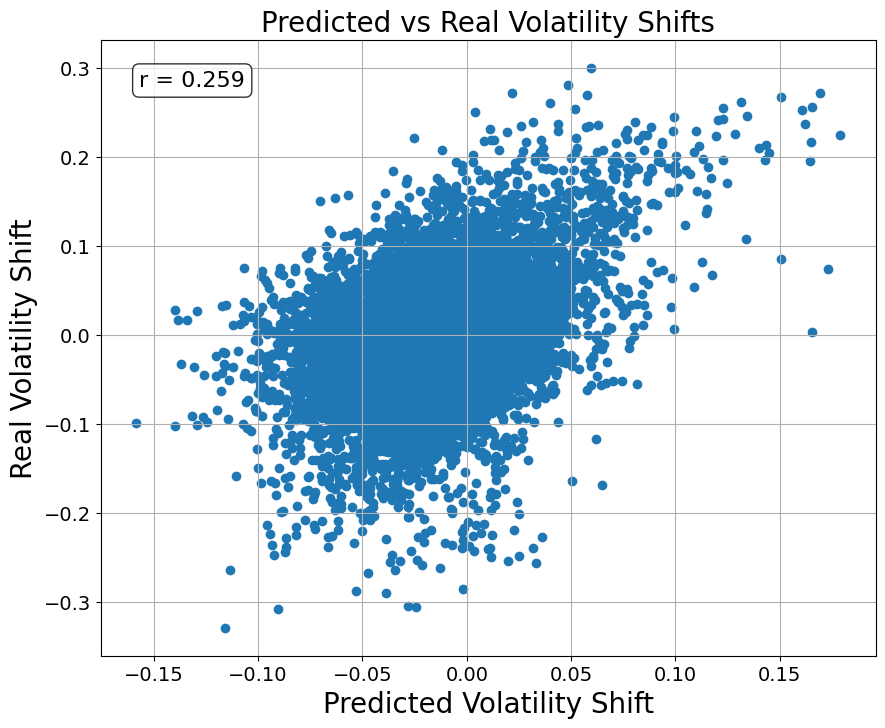

In [151]:
# Define the DataFrame column name that contains the model’s predicted volatility shift (x-axis variable).
x_col = "predicted_volatility_shift"
# Define the DataFrame column name that contains the realized/observed volatility shift (y-axis variable).
y_col = "real_volatility_shift"
# Compute the Pearson correlation coefficient between the predicted and real volatility shifts.
corr = df_vol[x_col].corr(df_vol[y_col])
# Create a Matplotlib figure and a single axes object with a 6x4 inch canvas.
fig, ax = plt.subplots(figsize=(10, 8))
# Draw a scatter plot of predicted shifts (x) versus real shifts (y), one point per row in df_vol.
ax.scatter(df_vol[x_col], df_vol[y_col])
# Set the x-axis label to describe the variable plotted on the horizontal axis.
ax.set_xlabel("Predicted Volatility Shift", fontsize=20)
# Set the y-axis label to describe the variable plotted on the vertical axis.
ax.set_ylabel("Real Volatility Shift", fontsize=20)
# Set the plot title (here it describes the comparison; the correlation is shown via an annotation below).
ax.set_title("Predicted vs Real Volatility Shifts", fontsize=20)
# Add text inside the axes using axes-relative coordinates:
# (0.05, 0.95) means 5% from the left and 95% from the bottom (near the top-left corner).
ax.text(
    0.05, 0.95,                 # Position of the annotation in axes coordinates (not data coordinates).
    f"r = {corr:.3f}",           # Text to display: correlation formatted to 3 decimal places.
    transform=ax.transAxes,      # Interpret (x, y) as axes-fraction coordinates in [0, 1] rather than data units.
    ha="left", va="top",         # Anchor the text box so the top-left corner sits at the given position.
    bbox=dict(                   # Draw a surrounding box behind the text for readability.
        boxstyle="round",        # Rounded corners on the text box.
        facecolor="white",       # White background to contrast with points.
        alpha=0.8               # Slight transparency so the plot remains visible behind the box.
    ), fontsize=16
)
# Enable grid lines to make it easier to visually assess alignment and dispersion.
ax.grid(True)
# Increase the font size of the x-axis tick labels (the numbers/labels along the bottom axis)
plt.xticks(fontsize=14)
# Increase the font size of the y-axis tick labels (the numbers/labels along the left axis)
plt.yticks(fontsize=14)
# Save the figure to a PNG file at 300 DPI, trimming excess whitespace around the plot.
fig.savefig("vol_shifts_correlation.png", dpi=300, bbox_inches="tight")
# Display the plot in the notebook/output.
plt.show()

In [152]:
# Compute the absolute strike level at time t from moneyness and the underlying spot price: K = (K/S)*S
df_vol["absolute_strike_t"] = df_vol["moneyness_t"] * df_vol["last_price_t"]
# Compute Black–Scholes d1 using spot S, strike K, risk-free rate r, volatility sigma (here: real_volatility_t), and time T (in years)
df_vol["d1"] = (
    np.log(df_vol["last_price_t"] / df_vol["absolute_strike_t"])                                  # ln(S/K)
    + (df_vol["risk_free_rate_t"] + 0.5 * df_vol["real_volatility_t"]**2) * df_vol["time_to_maturity_from_t"]  # (r + 0.5*sigma^2)*T
) / (df_vol["real_volatility_t"] * df_vol["time_to_maturity_from_t"]**0.5)                      # sigma*sqrt(T)
# Compute the standard normal PDF evaluated at d1: phi(d1) = exp(-0.5*d1^2) / sqrt(2*pi)
df_vol["phi_d1"] = np.exp(-0.5 * df_vol["d1"]**2) / (2 * math.pi)**0.5
# Compute Black–Scholes d2 = d1 - sigma*sqrt(T)
df_vol["d2"] = df_vol["d1"] - df_vol["real_volatility_t"] * df_vol["time_to_maturity_from_t"]**0.5
# Compute N(d2), the standard normal CDF at d2 (used in option pricing/Greeks)
df_vol["norm_d2"] = norm.cdf(df_vol["d2"])
# Compute N(-d2), the standard normal CDF at -d2 (used in put-related terms)
df_vol["norm_minus_d2"] = norm.cdf(-df_vol["d2"])
# Compute Black–Scholes vega for a call option (per 1.00 change in volatility, not per 1% unless scaled elsewhere): vega = S*phi(d1)*sqrt(T)
df_vol["vega_call"] = df_vol["last_price_t"] * df_vol["phi_d1"] * df_vol["time_to_maturity_from_t"]**0.5
# Approximate straddle vega as twice the call vega (call vega == put vega under Black–Scholes)
df_vol["vega_straddle"] = 2 * df_vol["vega_call"]
# Compute predicted vega P/L contribution for a long straddle using the model-predicted volatility shift: vega * Δσ_pred
df_vol["vega_predicted_PL"] = df_vol["vega_straddle"] * df_vol["predicted_volatility_shift"]
# Compute realized vega P/L contribution for a long straddle using the realized volatility shift: vega * Δσ_real
df_vol["vega_real_PL"] = df_vol["vega_straddle"] * df_vol["real_volatility_shift"]
# Compute an approximate call theta over the holding period (horizon days):
# - First compute the standard Black–Scholes call theta (per year), then scale to per-day by dividing by days_year,
#   and finally multiply by horizon to approximate theta decay over the holding horizon.
df_vol["theta_call_hd"] = (
    (-(df_vol["last_price_t"] * df_vol["phi_d1"] * df_vol["real_volatility_t"]) / (2 * np.sqrt(df_vol["time_to_maturity_from_t"]))  # diffusion term
     - df_vol["risk_free_rate_t"] * df_vol["absolute_strike_t"] * np.exp(-df_vol["risk_free_rate_t"] * df_vol["time_to_maturity_from_t"]) * norm.cdf(df_vol["d2"]))  # carry term
    / days_year                                                                 # convert from per-year theta to per-day theta
    * horizon                                                                   # scale theta to the holding period length (horizon days)
)

# Compute an approximate put theta over the holding period (horizon days) using the Black–Scholes put theta formula
df_vol["theta_put_hd"]  = (
    (-(df_vol["last_price_t"] * df_vol["phi_d1"] * df_vol["real_volatility_t"]) / (2 * np.sqrt(df_vol["time_to_maturity_from_t"]))  # diffusion term
     + df_vol["risk_free_rate_t"] * df_vol["absolute_strike_t"] * np.exp(-df_vol["risk_free_rate_t"] * df_vol["time_to_maturity_from_t"]) * norm.cdf(-df_vol["d2"]))  # carry term
    / days_year                                                                 # convert from per-year theta to per-day theta
    * horizon                                                                   # scale theta to the holding period length (horizon days)
)
# Compute straddle theta over the holding horizon as the sum of call theta and put theta
df_vol["theta_straddle_hd"] = df_vol["theta_call_hd"] + df_vol["theta_put_hd"]
# Compute the predicted P/L for a long straddle using the vega component plus theta component over the holding horizon
df_vol["predicted_PL_long"] = df_vol["vega_predicted_PL"] + df_vol["theta_straddle_hd"]
# Compute the predicted P/L for a short straddle as the negative of the long straddle's (vega + theta) approximation
df_vol["predicted_PL_short"] = -(df_vol["predicted_PL_long"])

In [167]:
# Filter the full per-grid-point DataFrame to keep only rows where the model predicts a sufficiently large profit
# for a SHORT straddle (here, predicted P/L > 10 in the notebook’s units)
df_candidates = df_vol[(df_vol["predicted_PL_long"] > 0) & (df_vol["predicted_volatility_shift"] > 0)].copy()
# For each trading date, find the row index (within df_candidates) that has the maximum predicted short-straddle P/L
# This selects the single “best” candidate grid point (moneyness, TTM) per date.
idx = df_candidates.groupby("date")["predicted_PL_long"].idxmax()
# Subset df_candidates to those best-per-date rows and reset the row index to 0..N-1 for a clean resulting table
df_best_candidate_date = df_candidates.loc[idx].reset_index(drop=True)

In [168]:
df_best_candidate_date

,date_t,last_price_t,moneyness_t,time_to_maturity_from_t,real_volatility_t,real_volatility_th,predicted_volatility_th,predicted_volatility_shift,real_volatility_shift,date,risk_free_rate_t,absolute_strike_t,d1,phi_d1,d2,norm_d2,norm_minus_d2,vega_call,vega_straddle,vega_predicted_PL,vega_real_PL,theta_call_hd,theta_put_hd,theta_straddle_hd,predicted_PL_long,predicted_PL_short
0,2021-02-01,134.14,0.90,1.561644,0.394437,0.376269,0.403075,0.008638,-0.018169,2021-02-01,0.0008,120.7260,0.462742,0.358437,-0.030170,0.487966,0.512034,60.084389,120.168779,1.037985,-2.183301,-0.104590,-0.103269,-0.207859,0.830126,-0.830126
1,2021-02-02,134.94,1.09,0.493151,0.318922,0.347853,0.338650,0.019728,0.028931,2021-02-02,0.0008,147.0846,-0.271045,0.384554,-0.495007,0.310298,0.689702,36.440794,72.881587,1.437780,2.108541,-0.161913,-0.160302,-0.322216,1.115564,-1.115564
2,2021-02-03,133.92,0.90,1.561644,0.382119,0.377686,0.394170,0.012051,-0.004433,2021-02-03,0.0008,120.5280,0.462017,0.358557,-0.015501,0.493816,0.506184,60.005943,120.011886,1.446244,-0.532066,-0.101219,-0.099900,-0.201119,1.245125,-1.245125
3,2021-02-04,137.39,0.90,1.561644,0.371065,0.373289,0.386774,0.015710,0.002224,2021-02-04,0.0008,123.6510,0.461761,0.358599,-0.001942,0.499225,0.500775,61.568037,123.136073,1.934408,0.273897,-0.100876,-0.099523,-0.200399,1.734009,-1.734009
4,2021-02-05,136.77,0.90,0.328767,0.392466,0.395275,0.427635,0.035169,0.002809,2021-02-05,0.0008,123.0930,0.581885,0.336811,0.356852,0.639399,0.360601,26.413207,52.826413,1.857845,0.148366,-0.216827,-0.215478,-0.432305,1.425540,-1.425540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2023-03-20,157.47,1.09,1.479452,0.282561,0.283280,0.321241,0.038681,0.000720,2023-03-20,0.0458,171.6423,0.118251,0.396163,-0.225435,0.410820,0.589180,75.879052,151.758105,5.870113,0.109254,-0.140603,-0.039970,-0.180574,5.689540,-5.689540
531,2023-03-21,159.29,1.09,1.479452,0.279214,0.283751,0.318147,0.038934,0.004538,2023-03-21,0.0458,173.6261,0.115573,0.396287,-0.224042,0.411362,0.588638,76.780079,153.560157,5.978681,0.696816,-0.141125,-0.039329,-0.180454,5.798227,-5.798227
532,2023-03-22,157.86,1.09,0.328767,0.130242,0.238074,0.263942,0.133700,0.107832,2023-03-22,0.0458,172.0674,-0.915012,0.262485,-0.989691,0.161163,0.838837,23.758578,47.517156,6.353033,5.123858,-0.081604,0.024737,-0.056867,6.296166,-6.296166
533,2023-03-23,158.88,1.09,1.479452,0.291365,0.278008,0.330541,0.039176,-0.013357,2023-03-23,0.0483,173.1792,0.135662,0.395288,-0.218734,0.413429,0.586571,76.389444,152.778889,5.985277,-2.040701,-0.147148,-0.040467,-0.187614,5.797663,-5.797663


In [169]:
# Normalize QUOTE_DATE to a date-only (midnight) timestamp to ensure consistent grouping/lookup by date
df_test_clean["QUOTE_DATE"] = pd.to_datetime(df_test_clean["QUOTE_DATE"]).dt.normalize()
# Normalize EXPIRE_DATE to a date-only (midnight) timestamp for consistent contract matching by expiry
df_test_clean["EXPIRE_DATE"] = pd.to_datetime(df_test_clean["EXPIRE_DATE"]).dt.normalize()
# Extract the unique trading dates present in the test dataset and sort them ascending
trading_dates = np.sort(df_test_clean["QUOTE_DATE"].unique())
# Convert the sorted array of unique dates into pandas datetime dtype (for consistent date arithmetic and indexing)
trading_dates = pd.to_datetime(trading_dates)
# Build a dictionary mapping each trading date to its integer index position in the trading_dates array
date_index = {d: i for i, d in enumerate(trading_dates)}
# Define a helper function that advances a given date by n trading days (using the trading_dates calendar)
def add_trading_days(d, n=horizon):
    # Look up the index of the provided date in the trading calendar; returns None if the date is not found
    i = date_index.get(d, None)
    # If the date is missing from the calendar or advancing n days would go past the available range, return NaT (missing date)
    if i is None or i + n >= len(trading_dates):
        return pd.NaT
    # Otherwise return the trading date that is n steps ahead in the trading calendar
    return trading_dates[i + n]
# For each selected candidate row, compute the exit date t+h by adding "horizon" trading days to the entry date
df_best_candidate_date["date_h"] = df_best_candidate_date["date"].map(lambda d: add_trading_days(d, horizon))
# Drop rows where the exit date is missing (e.g., near the end of the dataset where t+h is out of range)
df_best_candidate_date = df_best_candidate_date.dropna(subset=["date_h"])
# Precompute a groupby object to efficiently access all option quotes for a given quote date
grouped_by_date = df_test_clean.groupby("QUOTE_DATE")
# Define a function that, for a given candidate (date, moneyness, TTM), finds the nearest traded contract at time t
def find_nearest_contract_at_t(row):
    # Read the entry/quote date for this candidate row
    d = row["date"]
    # Retrieve the option chain for that specific quote date
    day = grouped_by_date.get_group(d)
    # Compute a simple squared-distance score between the candidate grid point and each traded quote:
    # distance in moneyness plus distance in TTM
    diff = ((day["RELATIVE_STRIKE"] - row["moneyness_t"])**2 + (day["TTM"] - row["time_to_maturity_from_t"])**2)
    # Get the index of the quote/row with the smallest distance score (best match)
    idx = diff.idxmin()
    # Pull out the matched option quote record (the nearest contract in (moneyness, TTM) space)
    match = day.loc[idx]
    # Return key fields for the matched contract as a small Series so it can be concatenated back to the candidate row
    return pd.Series(
        [
         match["EXPIRE_DATE"],   # expiration date of the matched contract
         match["STRIKE"],        # strike price of the matched contract
         match["TTM"],           # TTM of the matched contract at entry date t
         match["RELATIVE_STRIKE"], # moneyness (strike/spot) of the matched contract at entry date t
         match["C_BID"],         # call bid at entry date t (used for conservative short entry)
         match["P_BID"],         # put bid at entry date t (used for conservative short entry)
        ],
        index=["EXPIRE_DATE", "STRIKE", "TTM_t", "RELATIVE_STRIKE_t", "C_ASK_t", "P_ASK_t"]  # name the returned fields
    )
# Apply the matching function row-wise to obtain the nearest traded contract for every candidate row
contract_at_t = df_best_candidate_date.apply(find_nearest_contract_at_t, axis=1)
# Combine the candidate rows with their matched contract details into a new DataFrame used for the straddle backtest
df_straddles = pd.concat([df_best_candidate_date.copy(), contract_at_t], axis=1)
# Define a function that finds the exit prices (asks) for the same contract at time t+h, or a fallback near match
def get_prices_at_th(row):
    # Read the exit/quote date t+h for this trade
    d2 = row["date_h"]
    # Retrieve the option chain for the exit date
    day2 = grouped_by_date.get_group(d2)
    # Create a mask for the exact same contract (same strike and same expiry) on the exit date
    mask = ((day2["STRIKE"] == row["STRIKE"]) & (day2["EXPIRE_DATE"] == row["EXPIRE_DATE"]))
    # Subset to quotes that match the same strike/expiry contract on the exit date
    same_contract = day2[mask]
    # Compute the number of calendar days elapsed between entry date and exit date
    delta_years = (row["date_h"] - row["date"]).days/days_year
    # Compute the “expected” remaining TTM at exit by subtracting elapsed calendar days from the entry TTM
    target_ttm = row["TTM_t"] - delta_years
    # If the same strike/expiry contract exists on the exit date, pick the quote whose TTM is closest to target_ttm
    if not same_contract.empty:
        idx2 = (same_contract["TTM"] - target_ttm).abs().idxmin()  # choose closest TTM observation
        rec2 = same_contract.loc[idx2]                              # select that record
    else:
        # Otherwise fall back to the nearest contract in (moneyness, TTM) space on the exit date, targeting target_ttm
        diff2 = ((day2["RELATIVE_STRIKE"] - row["moneyness_t"])**2 + (day2["TTM"] - target_ttm)**2)
        idx2 = diff2.idxmin()                                       # index of best fallback match
        rec2 = day2.loc[idx2]                                       # select that fallback record
    # Return the exit prices using ask quotes (conservative for buying back a short position)
    return pd.Series(
        [rec2["C_BID"], rec2["P_BID"]],                             # call ask and put ask at exit
        index=["C_BID_th", "P_BID_th"],                             # name the returned fields
    )

# Apply the exit-price function row-wise to obtain (C_ASK, P_ASK) at t+h for each straddle trade
prices_th = df_straddles.apply(get_prices_at_th, axis=1)
# Append the exit ask prices columns to the straddles DataFrame
df_straddles = pd.concat([df_straddles, prices_th], axis=1)
# Position sizing: trade up to a fixed notional budget per entry (instead of 1 straddle)
TARGET_NOTIONAL = 100000.0
# Convert option quotes to $ notional per contract (100 shares per contract for US equity/ETF options)
CONTRACT_MULTIPLIER = 100.0
# Compute $ premium for 1 straddle at entry (sell at bid: call_bid + put_bid)
df_straddles["real_PL_straddle"] = (
    -(df_straddles["C_ASK_t"] + df_straddles["P_ASK_t"])
    +(df_straddles["C_BID_th"] + df_straddles["P_BID_th"]))
# Compute $ premium for 1 straddle at entry (sell at bid: call_bid + put_bid)
df_straddles["straddle_premium_per_contract"] = (
    (df_straddles["C_ASK_t"] + df_straddles["P_ASK_t"]) * CONTRACT_MULTIPLIER)
# Choose max whole straddles whose entry premium stays <= TARGET_NOTIONAL (floor sizing)
df_straddles["qty_straddles"] = np.floor(
    TARGET_NOTIONAL / df_straddles["straddle_premium_per_contract"]
).astype(int)
# Drop rows where even 1 straddle exceeds budget (qty becomes 0)
df_straddles = df_straddles[df_straddles["qty_straddles"] > 0].copy()
# Record number of call contracts per trade (1 call per straddle)
df_straddles["call_contracts"] = df_straddles["qty_straddles"]
# Record number of put contracts per trade (1 put per straddle)
df_straddles["put_contracts"]  = df_straddles["qty_straddles"]
# Entry cashflow in $ from selling qty straddles at bid
df_straddles["entry_credit"] = -(
    (df_straddles["C_ASK_t"] + df_straddles["P_ASK_t"])
    * CONTRACT_MULTIPLIER
    * df_straddles["qty_straddles"]
)
# Exit cashflow in $ for buying back qty straddles at ask (negative by convention)
df_straddles["exit_debit"] = +(
    (df_straddles["C_BID_th"] + df_straddles["P_BID_th"])
    * CONTRACT_MULTIPLIER
    * df_straddles["qty_straddles"]
)
# Total PnL = entry credit + exit debit
df_straddles["position_pnl"] = df_straddles["entry_credit"] + df_straddles["exit_debit"]
# Sanity check: actual entry notional used (should be <= TARGET_NOTIONAL)
df_straddles["entry_notional_used"] = (
    df_straddles["straddle_premium_per_contract"] * df_straddles["qty_straddles"]
)
df_straddles["predicted_position_PL"] = (
    df_straddles["predicted_PL_short"] * df_straddles["qty_straddles"] * CONTRACT_MULTIPLIER
)

In [170]:
df_straddles

,date_t,last_price_t,moneyness_t,time_to_maturity_from_t,real_volatility_t,real_volatility_th,predicted_volatility_th,predicted_volatility_shift,real_volatility_shift,date,risk_free_rate_t,absolute_strike_t,d1,phi_d1,d2,norm_d2,norm_minus_d2,vega_call,vega_straddle,vega_predicted_PL,vega_real_PL,theta_call_hd,theta_put_hd,theta_straddle_hd,predicted_PL_long,predicted_PL_short,date_h,EXPIRE_DATE,STRIKE,TTM_t,RELATIVE_STRIKE_t,C_ASK_t,P_ASK_t,C_BID_th,P_BID_th,real_PL_straddle,straddle_premium_per_contract,qty_straddles,call_contracts,put_contracts,entry_credit,exit_debit,position_pnl,entry_notional_used,predicted_position_PL
0,2021-02-01,134.14,0.90,1.561644,0.394437,0.376269,0.403075,0.008638,-0.018169,2021-02-01,0.0008,120.7260,0.462742,0.358437,-0.030170,0.487966,0.512034,60.084389,120.168779,1.037985,-2.183301,-0.104590,-0.103269,-0.207859,0.830126,-0.830126,2021-02-08,2022-09-16,120.0,1.621918,0.894588,33.05,18.50,33.55,16.16,-1.84,5155.0,19,19,19,-97945.0,94449.0,-3496.0,97945.0,-1577.239471
1,2021-02-02,134.94,1.09,0.493151,0.318922,0.347853,0.338650,0.019728,0.028931,2021-02-02,0.0008,147.0846,-0.271045,0.384554,-0.495007,0.310298,0.689702,36.440794,72.881587,1.437780,2.108541,-0.161913,-0.160302,-0.322216,1.115564,-1.115564,2021-02-09,2021-07-16,145.0,0.449315,1.074552,9.39,19.45,8.90,17.65,-2.29,2884.0,34,34,34,-98056.0,90270.0,-7786.0,98056.0,-3792.918121
2,2021-02-03,133.92,0.90,1.561644,0.382119,0.377686,0.394170,0.012051,-0.004433,2021-02-03,0.0008,120.5280,0.462017,0.358557,-0.015501,0.493816,0.506184,60.005943,120.011886,1.446244,-0.532066,-0.101219,-0.099900,-0.201119,1.245125,-1.245125,2021-02-10,2022-09-16,120.0,1.616438,0.896057,31.90,17.65,32.25,16.60,-0.70,4955.0,20,20,20,-99100.0,97700.0,-1400.0,99100.0,-2490.249530
3,2021-02-04,137.39,0.90,1.561644,0.371065,0.373289,0.386774,0.015710,0.002224,2021-02-04,0.0008,123.6510,0.461761,0.358599,-0.001942,0.499225,0.500775,61.568037,123.136073,1.934408,0.273897,-0.100876,-0.099523,-0.200399,1.734009,-1.734009,2021-02-11,2022-09-16,122.5,1.613699,0.891622,32.69,17.75,30.60,17.60,-2.24,5044.0,19,19,19,-95836.0,91580.0,-4256.0,95836.0,-3294.616985
4,2021-02-05,136.77,0.90,0.328767,0.392466,0.395275,0.427635,0.035169,0.002809,2021-02-05,0.0008,123.0930,0.581885,0.336811,0.356852,0.639399,0.360601,26.413207,52.826413,1.857845,0.148366,-0.216827,-0.215478,-0.432305,1.425540,-1.425540,2021-02-12,2021-06-18,122.5,0.364384,0.895664,19.85,5.55,18.40,5.40,-1.60,2540.0,39,39,39,-99060.0,92820.0,-6240.0,99060.0,-5559.605243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2023-03-20,157.47,1.09,1.479452,0.282561,0.283280,0.321241,0.038681,0.000720,2023-03-20,0.0458,171.6423,0.118251,0.396163,-0.225435,0.410820,0.589180,75.879052,151.758105,5.870113,0.109254,-0.140603,-0.039970,-0.180574,5.689540,-5.689540,2023-03-27,2024-09-20,170.0,1.506849,1.079571,20.20,24.40,20.15,23.75,-0.70,4460.0,22,22,22,-98120.0,96580.0,-1540.0,98120.0,-12516.986954
531,2023-03-21,159.29,1.09,1.479452,0.279214,0.283751,0.318147,0.038934,0.004538,2023-03-21,0.0458,173.6261,0.115573,0.396287,-0.224042,0.411362,0.588638,76.780079,153.560157,5.978681,0.696816,-0.141125,-0.039329,-0.180454,5.798227,-5.798227,2023-03-28,2024-09-20,175.0,1.504110,1.098625,18.75,25.80,17.85,26.70,0.00,4455.0,22,22,22,-98010.0,98010.0,0.0,98010.0,-12756.098989
532,2023-03-22,157.86,1.09,0.328767,0.130242,0.238074,0.263942,0.133700,0.107832,2023-03-22,0.0458,172.0674,-0.915012,0.262485,-0.989691,0.161163,0.838837,23.758578,47.517156,6.353033,5.123858,-0.081604,0.024737,-0.056867,6.296166,-6.296166,2023-03-29,2023-07-21,170.0,0.331507,1.076904,5.95,15.05,6.10,13.35,-1.55,2100.0,47,47,47,-98700.0,91415.0,-7285.0,98700.0,-29591.978291
533,2023-03-23,158.88,1.09,1.479452,0.291365,0.278008,0.330541,0.039176,-0.013357,2023-03-23,0.0483,173.1792,0.135662,0.395288,-0.218734,0.413429,0.586571,76.389

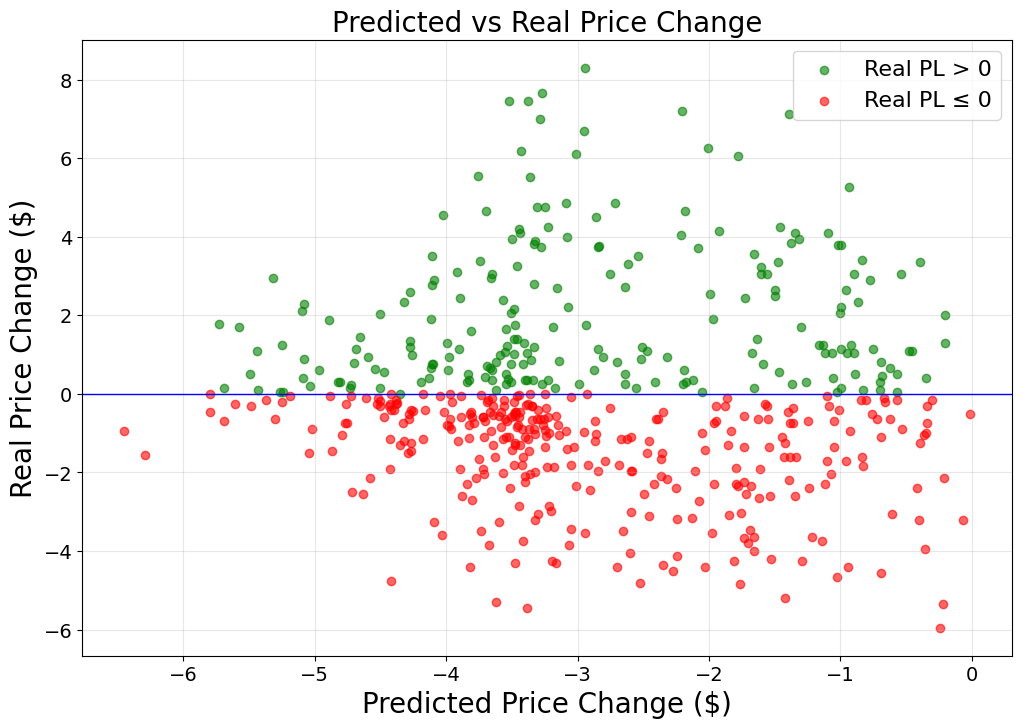

In [171]:
# Select only the two columns needed for the comparison (predicted vs real) and remove rows with missing values.
plot_df = df_straddles[['predicted_PL_short', 'real_PL_straddle']].dropna()
# Extract the predicted short P&L series to use as the x-axis values.
x = plot_df['predicted_PL_short']
# Extract the realized straddle P&L series to use as the y-axis values.
y = plot_df['real_PL_straddle']
# Create a boolean mask that is True where the real value is strictly positive (profit) and False otherwise.
pos = y > 0
# Create the complementary mask for non-positive outcomes (losses and zeros) by negating `pos`.
neg = ~pos  # includes y == 0 as "non-positive"; change to (y < 0) if you want zero separate
# Create a new Matplotlib figure with a 10x6 inch canvas to control the output size.
plt.figure(figsize=(12, 8))
# Scatter-plot the points where the real value is positive, coloring them green and applying transparency.
plt.scatter(x[pos], y[pos], alpha=0.6, c='g', label='Real PL > 0')
# Scatter-plot the points where the real value is non-positive, coloring them red and applying transparency.
plt.scatter(x[neg], y[neg], alpha=0.6, c='r', label='Real PL ≤ 0')
# Draw a horizontal reference line at y = 0 to visually separate positive and negative real outcomes.
plt.axhline(0, linewidth=1, color="b")
# Label the x-axis to indicate it represents the model's predicted price change (as defined by `predicted_PL_short`).
plt.xlabel('Predicted Price Change ($)', fontsize=20)
# Label the y-axis to indicate it represents the realized price change (as defined by `real_PL_straddle`).
plt.ylabel('Real Price Change ($)', fontsize=20)
# Set the plot title displayed at the top of the figure.
plt.title('Predicted vs Real Price Change', fontsize=20)
# Enable a light grid to improve readability; alpha controls the grid line transparency.
plt.grid(True, alpha=0.3)
# Increase the font size of the x-axis tick labels (the numbers/labels along the bottom axis)
plt.xticks(fontsize=14)
# Increase the font size of the y-axis tick labels (the numbers/labels along the left axis)
plt.yticks(fontsize=14)
# Add a legend explaining the color coding, using the labels provided in the scatter calls.
plt.legend(fontsize=16)
# Save the figure as a PNG file at 300 DPI, trimming extra whitespace around the plot area.
plt.savefig("predicted_real_price_change.png", dpi=300, bbox_inches="tight")
# Render the plot in the notebook/output cell.
plt.show()

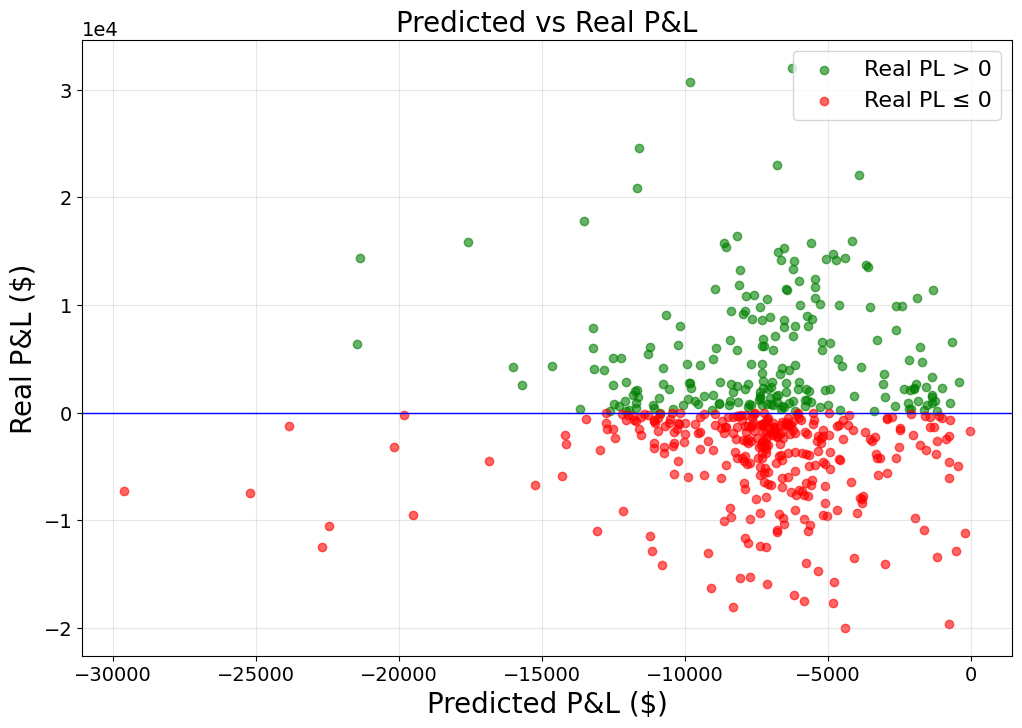

In [172]:
# Select only the two P&L columns we want to compare and drop any rows where either value is missing (NaN).
plot_df = df_straddles[['predicted_position_PL', 'position_pnl']].dropna()
# Extract the "predicted" P&L series to use as the x-axis values in the scatter plot.
x = plot_df['predicted_position_PL']
# Extract the "real/actual" P&L series to use as the y-axis values in the scatter plot.
y = plot_df['position_pnl']
# Create a boolean mask that is True where the real P&L is strictly positive (profit) and False otherwise.
pos = y > 0
# Create the complementary mask for non-positive outcomes (losses and zeros) by negating `pos`.
# Note: this treats y == 0 as non-positive; use (y < 0) if you want to exclude zeros from `neg`.
neg = ~pos  # includes y == 0 as "non-positive"; change to (y < 0) if you want zero separate
# Create a new Matplotlib figure with a 10x6 inch canvas to control the plot size.
plt.figure(figsize=(12, 8))
# Plot the profit points: x and y values where the real P&L is positive, using green markers with some transparency.
plt.scatter(x[pos], y[pos], alpha=0.6, c='g', label='Real PL > 0')
# Plot the non-positive points: x and y values where the real P&L is zero or negative, using red markers with some transparency.
plt.scatter(x[neg], y[neg], alpha=0.6, c='r', label='Real PL ≤ 0')
# Draw a horizontal reference line at y=0 to visually separate profits (above) from losses (below).
plt.axhline(0, linewidth=1, color="b")
# Label the x-axis to indicate it represents predicted P&L values.
plt.xlabel('Predicted P&L ($)', fontsize=20)
# Label the y-axis to indicate it represents realized/actual P&L values.
plt.ylabel('Real P&L ($)', fontsize=20)
# Set the plot title displayed at the top of the figure.
plt.title('Predicted vs Real P&L', fontsize=20)
# Turn on a grid to make it easier to read values; alpha controls grid transparency.
plt.grid(True, alpha=0.3)
# Get the current Matplotlib Axes object (the plotting area of the current figure)
ax = plt.gca()
# Force scientific notation on the y-axis tick labels (so an offset like "1e4" can appear)
ax.ticklabel_format(axis="y", style="sci", scilimits=(4, 4))
# Increase the font size of the y-axis scientific-notation offset text (e.g., the "1e4" shown near the axis)
ax.yaxis.get_offset_text().set_fontsize(14)
# Increase the font size of the x-axis tick labels (the numbers/labels along the bottom axis)
plt.xticks(fontsize=14)
# Increase the font size of the y-axis tick labels (the numbers/labels along the left axis)
plt.yticks(fontsize=14)
# Add a legend that maps colors to meaning (profit vs non-positive), using the labels given in the scatter calls.
plt.legend(fontsize=16)
# Save the current figure to disk at 300 DPI, cropping extra whitespace around the plot.
plt.savefig("predicted_real_pnl", dpi=300, bbox_inches="tight")
# Render the figure in the notebook/output window.
plt.show()

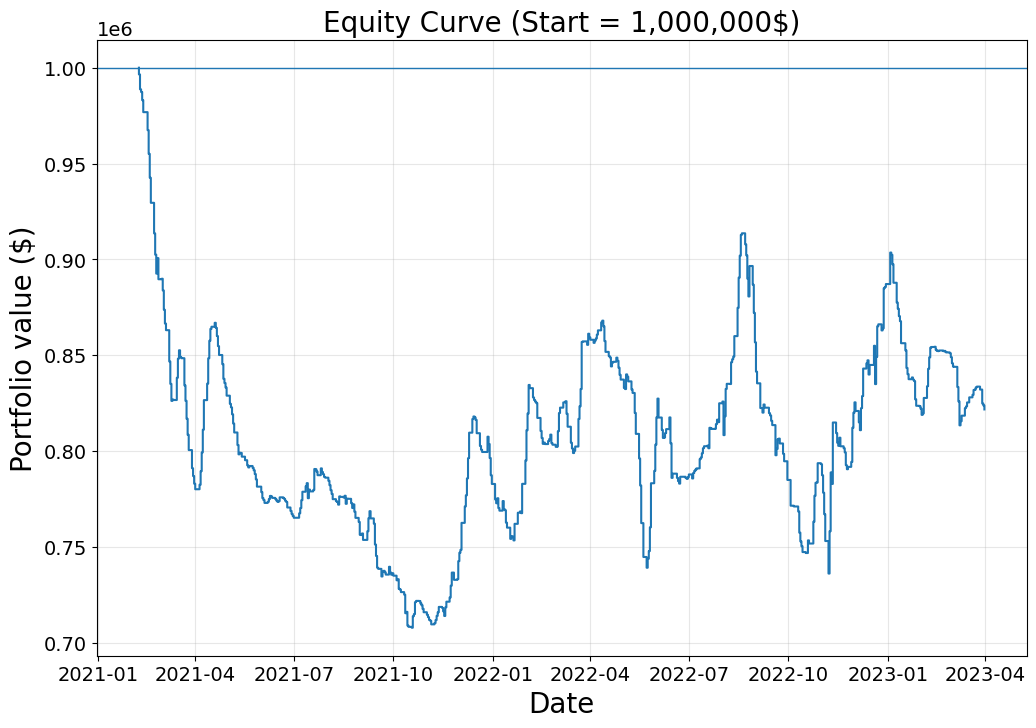

In [173]:
# Set the starting portfolio equity (initial capital) to 1,000,000.
START_CAPITAL = 1_000_000
# Store the name of the date column (used for time indexing and the x-axis in the equity curve plot).
date_col = "date_h"
# Store the name of the realized P/L column (cash P/L per trade that will be aggregated into daily P/L).
pl_col   = "position_pnl"
# Build a working DataFrame containing only the date and P/L columns, drop rows with NaNs, and copy to avoid chained assignment issues.
dfp = df_straddles[[date_col, pl_col]].dropna().copy()
# Convert the date column to pandas datetime so grouping/sorting behaves correctly and the x-axis formats as dates.
dfp[date_col] = pd.to_datetime(dfp[date_col])
# Sort the rows by date so that subsequent cumulative calculations produce a time-consistent equity series.
dfp = dfp.sort_values(date_col)
# Group trades by date and sum P/L for each day (daily P/L), then sort by date index to ensure chronological ordering.
daily_pl = dfp.groupby(date_col, as_index=True)[pl_col].sum().sort_index()
# Compute the equity curve by adding cumulative daily P/L to the starting capital.
equity = START_CAPITAL + daily_pl.cumsum()
# Set the end date for the plot as the last date in df_vol plus 7 days (to extend the chart beyond the last observation).
end_date = pd.to_datetime(df_vol["date"].iloc[-1]) + pd.Timedelta(days=7)
# Identify the first date where daily P/L exists (i.e., the earliest date in the equity series).
start_date = daily_pl.index.min()
# Create a new equity series that explicitly includes the starting capital at `start_date`,
# then append the computed equity series; this ensures the chart visibly starts at START_CAPITAL.
equity_with_start = pd.concat(
    [pd.Series([START_CAPITAL], index=[start_date]), equity]
).sort_index()
# Extend the equity series by appending one more point at `end_date` with the last equity value,
# so a step plot stays flat through the chosen end date.
equity_ext = pd.concat(
    [equity_with_start, pd.Series([equity_with_start.iloc[-1]], index=[end_date])]
)
# Create a new Matplotlib figure sized 12x6 inches for the equity curve plot.
plt.figure(figsize=(12, 8))
# Plot the equity series as a step function; 'where="post"' holds each value constant until the next timestamp.
plt.step(equity_ext.index, equity_ext.values, where="post")
# Add a horizontal reference line at the starting capital to show the initial equity baseline.
plt.axhline(START_CAPITAL, linewidth=1)
# Set the chart title (explicitly stating the starting capital for clarity).
plt.title("Equity Curve (Start = 1,000,000$)", fontsize=20)
# Label the x-axis as Date since the index is a datetime series.
plt.xlabel("Date", fontsize=20)
# Label the y-axis to indicate the values are total portfolio equity over time.
plt.ylabel("Portfolio value ($)", fontsize=20)
# Turn on a light grid to improve readability of the curve against the axes.
plt.grid(True, alpha=0.3)
# Increase the font size of the x-axis tick labels (the numbers/labels along the bottom axis)
plt.xticks(fontsize=14)
# Increase the font size of the y-axis tick labels (the numbers/labels along the left axis)
plt.yticks(fontsize=14)
# Takes current axes
ax = plt.gca() 
# Make the scientific-notation offset text bigger
ax.yaxis.get_offset_text().set_fontsize(14)
# Save the plot to a PNG file with 300 DPI resolution and tight bounding box to reduce extra whitespace.
plt.savefig("equity_evolution.png", dpi=300, bbox_inches="tight")
# Display the plot in the notebook/output.
plt.show()